In [1]:
from __future__ import print_function

In [11]:
#downloading youtube audio
from __future__ import unicode_literals
import youtube_dl


ydl_opts = {
    'format': 'bestaudio/best',
    'postprocessors': [{
        'key': 'FFmpegExtractAudio',
        'preferredcodec': 'wav',
        'preferredquality': '192',
    }],
}

with youtube_dl.YoutubeDL(ydl_opts) as ydl:
    ydl.download(['https://www.youtube.com/watch?v=GLkT2D91YUM'])

[youtube] GLkT2D91YUM: Downloading webpage
[youtube] GLkT2D91YUM: Downloading video info webpage
[download] Destination: Brazil World Cup Final 2014 - Germany vs Argentina - 2nd Half (Full HD)-GLkT2D91YUM.m4a
[download] 100% of 140.94MiB in 00:1740MiB/s ETA 00:008
[ffmpeg] Correcting container in "Brazil World Cup Final 2014 - Germany vs Argentina - 2nd Half (Full HD)-GLkT2D91YUM.m4a"
[ffmpeg] Destination: Brazil World Cup Final 2014 - Germany vs Argentina - 2nd Half (Full HD)-GLkT2D91YUM.wav
Deleting original file Brazil World Cup Final 2014 - Germany vs Argentina - 2nd Half (Full HD)-GLkT2D91YUM.m4a (pass -k to keep)


In [24]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Audio
import numpy as np
from pyAudioAnalysis import audioTrainTest as aT


In [25]:
def load_audio_slice(file_name,offset_in_sec,period_in_sec):
    y, sr = librosa.load(file_name,  
                       duration=period_in_sec,offset=offset_in_sec)
    return y,sr



In [26]:
def computeAbsMagandPhase(y,sr):
    # And compute the spectrogram magnitude and phase
    S_full, phase = librosa.magphase(librosa.stft(y))
    S=np.abs(librosa.stft(y))
    
    return S,S_full,phase

In [27]:
def SeparateVoiceAndBackground(S_full,phase,sr):
    ###########################################################
    # The wiggly lines above are due to the vocal component.
    # Our goal is to separate them from the accompanying
    # instrumentation.
    #

    # We'll compare frames using cosine similarity, and aggregate similar frames
    # by taking their (per-frequency) median value.
    #
    # To avoid being biased by local continuity, we constrain similar frames to be
    # separated by at least 2 seconds.
    #
    # This suppresses sparse/non-repetetitive deviations from the average spectrum,
    # and works well to discard vocal elements.
    S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(2, sr=sr)))
    # The output of the filter shouldn't be greater than the input
    # if we assume signals are additive.  Taking the pointwise minimium
    # with the input spectrum forces this.
    S_filter = np.minimum(S_full, S_filter)
    ##############################################
    # The raw filter output can be used as a mask,
    # but it sounds better if we use soft-masking.

    # We can also use a margin to reduce bleed between the vocals and instrumentation masks.
    # Note: the margins need not be equal for foreground and background separation
    margin_i, margin_v = 2, 10
    power = 2

    mask_i = librosa.util.softmask(S_filter,
                               margin_i * (S_full - S_filter),
                               power=power)

    mask_v = librosa.util.softmask(S_full - S_filter,
                               margin_v * S_filter,
                               power=power)

    # Once we have the masks, simply multiply them with the input spectrum
    # to separate the components

    S_foreground = mask_v * S_full
    S_background = mask_i * S_full
    return S_foreground, S_background


In [28]:
def audio_convertor(input_file,chunk_number,file_type,S_Type,phase,sr):
    librosa.output.write_wav(str(input_file)+"_"+str(chunk_number)+"_"+str(file_type)+".wav", librosa.istft(S_Type* phase), sr)
    

In [49]:
import csv
def EmotionAnalyzerSVM(slice_audio_dir,model_path,file_name,interval):
    y, sr = librosa.load(file_name+".wav")
    duration= librosa.get_duration(y=y, sr=sr)
    print("The duration of the file :"+file_name+ " is "+str(duration))

    with open('emotional_analysis_data.csv','w') as outfile: 
        columns=["from","to","next_offset","Full_Arousal","Full_Valence","Foreground_Arousal","Foreground_Valence","Background_Arousal","Background_Valence"]
        w = csv.DictWriter(outfile,fieldnames=columns)
        w.writeheader()
        for i in range(0,int(duration),interval/2):
            #print("creating audio slice from "+ str(i)+ " sec to " +str(i+interval)+ " sec")
            y, sr=load_audio_slice(file_name+".wav",i,interval)
            S,S_full,phase=computeAbsMagandPhase(y,sr)
            S_foreground,S_background=SeparateVoiceAndBackground(S_full,phase,sr)
            from_duration=i
            to_duration=interval+i
            next_offset=i+interval/2
            chunk=str(from_duration)+"to"+str(to_duration)+"sec"
            #print("saving full spectrum audio wave file")
            audio_convertor(file_name[0:15],chunk,"S_full",S_full,phase,sr)
            audio_convertor(file_name[0:15],chunk,"S_foreground",S_foreground,phase,sr)
            audio_convertor(file_name[0:15],chunk,"S_background",S_background,phase,sr)
            outfile.write(str(from_duration)+','
                              +str(to_duration)+','
                              +str(next_offset)+',')
            try:
                sentiment=aT.fileRegression(slice_audio_dir+file_name[0:15]+"_"+chunk+"_"+"S_full"+".wav",model_path, "svm")[0]
                #print("sentiment for Full Spectrum"+chunk+"- Arousal:"+sentiment[0]+"; Valence:"+sentiment[1] )
                outfile.write(str(sentiment[0])+','
                              +str(sentiment[1])+',')
            except TypeError:
                pass
            try:
                sentiment2=aT.fileRegression(slice_audio_dir+file_name[0:15]+"_"+chunk+"_"+"S_foreground"+".wav", model_path, "svm")[0]
                #print("sentiment for Foreground"+chunk+"- Arousal:"+sentiment2[0]+"; Valence:"+sentiment2[1] )
                outfile.write(
                             str(sentiment2[0])+','
                              +str(sentiment2[1])+',')
            except TypeError:
                pass
            try:
                sentiment3=aT.fileRegression(slice_audio_dir+file_name[0:15]+"_"+chunk+"_"+"S_background"+".wav", model_path, "svm")[0]
                #print("sentiment for background"+chunk+"- Arousal:"+sentiment3[0]+"; Valence:"+sentiment3[1] )
                outfile.write(
                             str(sentiment3[0])+','
                             +str(sentiment3[1]))
            except TypeError:
                pass
            
            outfile.write("\n")
        

In [50]:
youtube_audio_title="Brazil World Cup Final 2014 - Germany vs Argentina - 2nd Half (Full HD)-GLkT2D91YUM"
slice_audio_dir="/Users/babu/Emotion Analytics/"
model_path="/Users/babu/pyAudioAnalysis/data/svmSpeechEmotion"
emotion_analyzer_interval=10
EmotionAnalyzerSVM(str(slice_audio_dir),str(model_path),str(youtube_audio_title),emotion_analyzer_interval)

The duration of the file :Brazil World Cup Final 2014 - Germany vs Argentina - 2nd Half (Full HD)-GLkT2D91YUM is 3069.20535147


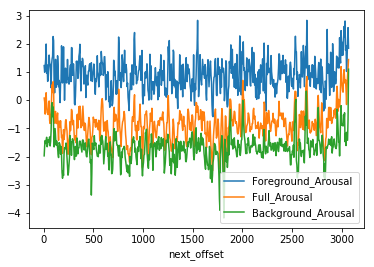

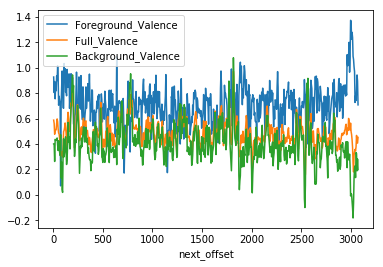

In [67]:
import pandas as pd
df = pd.read_csv('emotional_analysis_data.csv', index_col=2)
df1=df[['Foreground_Arousal','Full_Arousal','Background_Arousal']]
df1.plot(x=df.index,y=df1.columns)
df2=df[['Foreground_Valence','Full_Valence','Background_Valence']]
df2.plot(x=df.index,y=df2.columns)
